In [61]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import os

In [62]:
device = torch.device("cuda")

In [63]:
import torch.utils.data.dataloader


transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder("./train/", transform=transform)

ratio = 0.2
val_size = int(len(dataset) * ratio)
train_size = len(dataset) - val_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True, num_workers=4)


classes = sorted([x[0].replace("./train/","" ) for x in os.walk("./train")])[1:] 
print(len(classes))

50


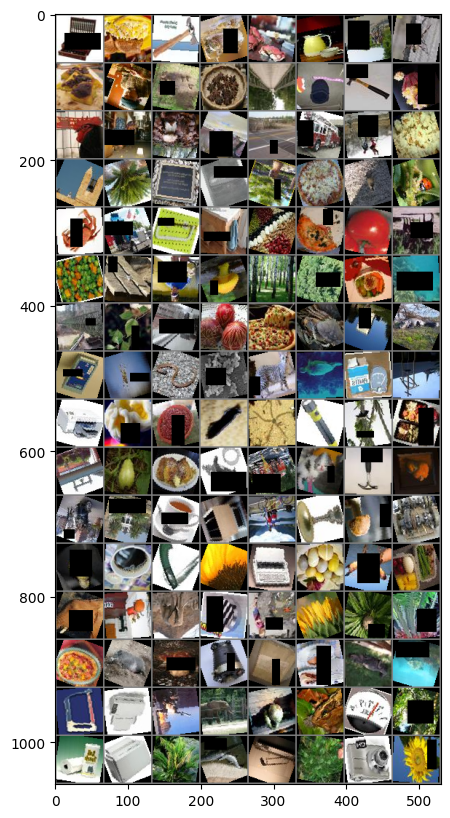

spoon bread hammer squash  crab   pot bicycle spider squash  crab swine spice bridge   pot hammer  corn  bird  crab fungus   cat bridge truck bicycle  corn acoustic  palm memorial memorial  palm pizza  bird beetle


torch.Size([1, 3, 64, 64])

In [64]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
images[0:1].size()

In [89]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Warstwa konwolucyjna 1: 3 kanały wejściowe (RGB), 32 filtry wyjściowe
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=0)  # 32x32x3 -> 28x28x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                         # 28x28x32 -> 14x14x32
        
        # Warstwa konwolucyjna 2: 32 kanały wejściowe, 64 filtry wyjściowe
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) # 14x14x32 -> 10x10x64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                         # 10x10x64 -> 5x5x64
        
        # Warstwy gęste
        self.fc1 = nn.Linear(10816, 512)  # 5x5x64 = 1600 -> 512
        self.fc2 = nn.Linear(512, 128)         # 512 -> 128
        self.fc3 = nn.Linear(128, 50)          # 128 -> 50 (dla 50 klas)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)  # Spłaszcza wszystkie wymiary oprócz batcha

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Brak Softmax, bo CrossEntropyLoss to załatwi
        return x




In [90]:
model = Net().to(device="cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [93]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    # running_loss = 0.0
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for data in val_loader:
    #         images, labels = data
    #         images = images.to(device)
    #         # calculate outputs by running images through the network 
    #         outputs = model(images)
    #         # the class with the highest energy is what we choose as prediction
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()

    # print('Accuracy of the network on the 10000 test images: %d %%' % (
    #     100 * correct / total))

print('Finished Training')

KeyboardInterrupt: 

# Final evaluation

In [ ]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

In [ ]:
test_mapping = pd.read_csv("data/test_mapping")

In [ ]:
pd.DataFrame({"a":test_mapping.img, "b":np.random.randint(0,50,len(test_mapping))}).to_csv("all_pia/results/random.csv", index=False, header=None)

In [ ]:
import os
directory = "results/poniedzialek/all_pon/"
files = os.listdir(directory)

In [ ]:
results = pd.DataFrame()
for file in files:
    try:
        if file[-4:]==".csv":
            team_name = file[:-4]
        else:
            team_name = file
        predictions = pd.read_csv(directory+file, header=None)
        if len(predictions.columns)!=2:
            print(f"Warning: more columns for team {team_name}")
            pred_scores = predictions.merge(test_mapping,left_on=1,right_on="img")
            scores = pred_scores[2]
        else:
            pred_scores = predictions.merge(test_mapping,left_on=0,right_on="img")
            scores = pred_scores[1]

        accuracy = (scores == pred_scores.cl).sum()/len(test_mapping)
        print(len(scores), len(pred_scores))
        results = results.append({"team":team_name,"accuracy":accuracy},ignore_index=True)
    except:
        print(f"Error for {file}")
        continue
    print(team_name,accuracy)

In [ ]:
results.sort_values("accuracy",ascending=False)